# Combining behavioral and neurophysiological data


The goal of this workshop is to introduce a way of combining neurophysiological data and behavioral observations, on recordings of human EEG in a discrimination task. 

## 1. Description of the experiment and data

In this task, participants were presented at each trial either with an image of a face or a sound, and had to report what they have perceived through key presses (left arrow=sound, right arrow=face) as fast and accuately as possible. A timeout on response time would occur two seconds after stimulus presentation. 

The experiment is split into two parts:
- a calibration phase, where the stimuli were preceded by a predictive cue, i.e. a stimulus to which participants did not have to response, but that predicted with a 80% accuracy the stimulus that is coming next
- a test phase, whose sequence does not include cues.

While performing this task, their EEG activity was recorded using 32 channels (including a reference, located in Fz), along with their response class and time. All information is contained in the EEG recording, that tracks all that happens and when it happens (EEG activity and experiment events). The experiment events are encoded as "markers", and are each associated with a type-specific number.

The experiment goes as follows:
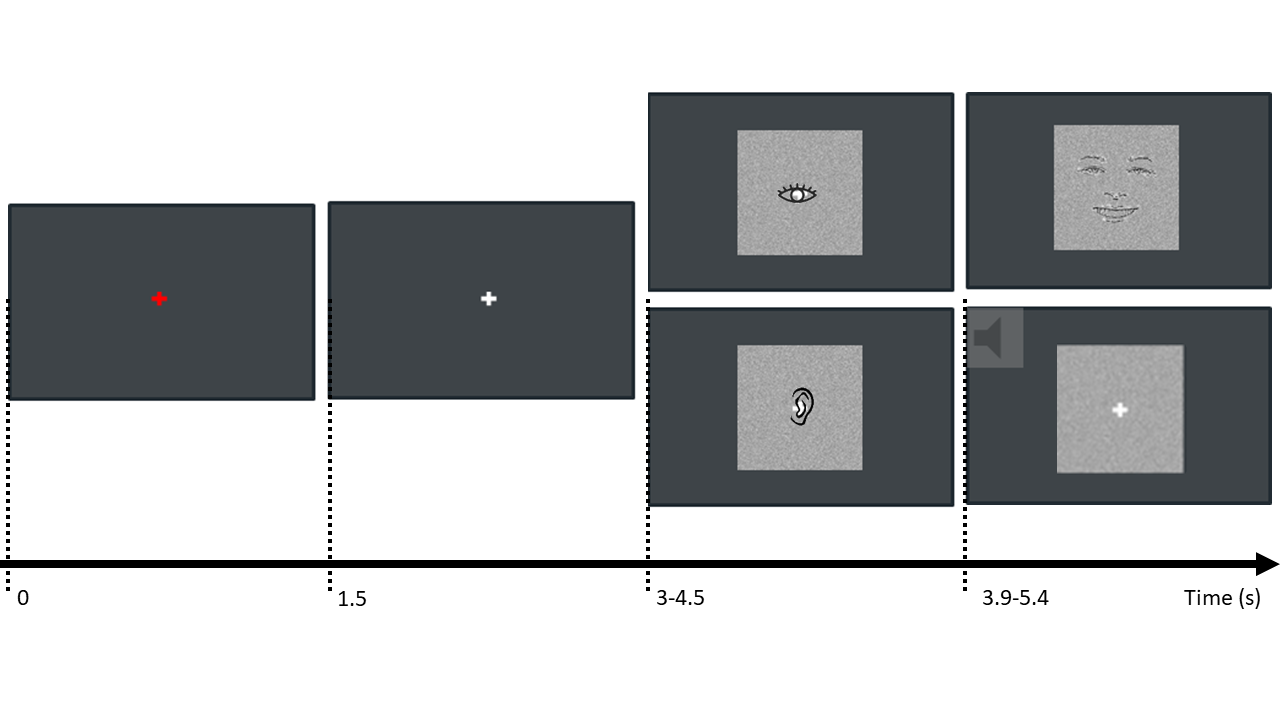
During the red cross, participants can blink and move slightly. They are instructed to start focusing as soon as the white cross is displayed, and they are presented with a cue after a few seconds (between 1.5 and 3). This cue is either the image of an eye or an ear, and it predicts with ~80% accuracy the stimulus that is coming next (eye->face image, ear->sound).

You can find below a list of the possible markers you will find in data:

|Marker|Event description|
|:-:|:-:|
|1|Cue "eye" is presented|
|2|Cue "ear" is presented|
|8|Trial is strating, red cross appearing|
|9|White cross appearing|
|11|Stimulus "face" is presented|
|12|Stimulus "sound" is presented|
|14|Block starts|
|1001|Participant answers "right" (ie "face")|
|1002|Participant answers "left" (ie "sound")|

In [ ]:
# imports and utility functions
import numpy as np
import mne
import matplotlib.pyplot as plt
import mne
from collections import Counter
import pandas as pd

In [ ]:
#%% import and preprocessing
def import_raw(datapath,nblock):
    '''Imports raw data as an MNE structure.
    Input: datapath (str) path to reach data files.
    Ouput: eegdata (MNE.Raw) relevant data'''
    eegdatas=[0 for i in range(nblock)]
    for b in range (nblock):
        filename=datapath.format(b+1)
        vhdr_fname=filename+'.vhdr';
        eegdatas[b]=mne.io.read_raw_brainvision(vhdr_fname,preload=True)
        
    eegdata=mne.concatenate_raws(eegdatas,preload=True)
    montage1020 = mne.channels.make_standard_montage('standard_1020')
    eegdata = eegdata.set_montage(montage1020)
    return eegdata

def get_rej_trials(drop_log):
    '''From a drop log, get the index of trials that have been rejected'''
    ix_list=[]
    for i,t in enumerate(drop_log):
        if len(t)!=0:
            ix_list.append(i)
    return ix_list

def get_bad_stats(drop_log):
    scores = Counter([ch for d in drop_log for ch in d])
    return scores

def get_bad_channels_trials(eegdata,event_id,thresh_trial=110e-6,thresh_chans=0.15,tmin=-1,tmax=3,reject_tmin=-0.9,reject_tmax=0.5):
    '''Returns bad channels and trials given the specified thresholds.
    Inputs:
        thresh_trial: (default 100e-6) threshold value from which an epoch should be rejected (in V)
        thresh_chans: (default 0.15) proportion of trials rejected to decide to reject channels. Should be between 0 and 1
    Outputs:
        rej_trials: list of trial indices that should be rejected
        rej_channels: list of str of the rejected channels'''
        
    all_evt,evt_dict=mne.events_from_annotations(eegdata)
    stim_ix=np.where((all_evt[:,2]==event_id[0]) | (all_evt[:,2]==event_id[1]))[0]
    events=all_evt[stim_ix,:]
    
    rej_dict=dict(eeg=thresh_trial)
    ep = mne.Epochs(eegdata, events, baseline=None,tmin=tmin, tmax=tmax,reject=rej_dict,reject_tmin=reject_tmin,reject_tmax=reject_tmax, preload=True)
    drop_log=list(ep.drop_log)
    stats=len(get_rej_trials(drop_log))/len(events) #ep.drop_log_stats()
    stat_details=get_bad_stats(drop_log)
    rej_trials=get_rej_trials(drop_log)
    rej_channels=[]
    ch=0
    while stats>thresh_chans and ch<eegdata.info['nchan']:
        chan_to_rej=stat_details.most_common()[0][0]
        rej_channels.extend([chan_to_rej])
        for i in range(len(drop_log)):
            if chan_to_rej in drop_log[i]:
                new_log=list(drop_log[i])
                new_log.remove(chan_to_rej)
                if new_log is None:
                    drop_log[i]=()
                else:
                    drop_log[i]=tuple(new_log)
        stats=len(get_rej_trials(drop_log))/len(events)
        stat_details=get_bad_stats(drop_log)
        ch+=1
    rej_trials=get_rej_trials(drop_log)
    return rej_trials,rej_channels

def get_epochs(eegdata,event_id,tmin,tmax):
    events, event_dict = mne.events_from_annotations(eegdata)
    evt_ix=np.where(events[:,2]==event_id[0])
    for ix in range(1,len(event_id)):
        evt_ix=np.hstack((evt_ix, np.where(events[:,2]==event_id[ix])))
    stim_events=np.squeeze(events[evt_ix])
    stim_events=np.sort(stim_events.view('int,int,int'), order=['f1'], axis=0).view(np.int)

    metadata = {'event_time': stim_events[:, 0],
                'trial_number': range(len(stim_events))}#
    metadata = pd.DataFrame(metadata)
    
    epochs = mne.Epochs(eegdata, stim_events, event_id, tmin, tmax, proj=True, baseline=None, metadata=metadata, detrend=0, preload=True,event_repeated='merge')
    return epochs


#%% plotting functions
def plot_ERP(epochs,events):
    for e in events:
        ev=epochs[e].average()
        ev.plot_joint(title=e)
    all_ev=epochs.average()
    all_ev.plot_joint(title='All conditions')
    return

## 2. Import and visualize data
In this first part we look at raw data and see how we can improve it.

In [ ]:
# import raw data
my_path=... #COMPLETE HERE WITH YOUR PATH to the data
datapath=my_path+'959_calib_000{}'
#datapath_test=my_path+'959_test_000{}'
nblocks=4
nblocks_test=3

In [ ]:
eegdata=import_raw(datapath,nblocks)

# plot electrode location
eegdata.plot_sensors(show_names=True)

# epoch data
events=[11,12]
tmin=-1
tmax=0.5
epochs=get_epochs(eegdata, events,tmin=tmin, tmax=tmax)

# plot ERP
plot_ERP(epochs,['11','12'])

We can see that the data is quite messy, as it is prone to artifacts. In fact, with EEG, any small movement can appear in the signal, from blinking, to sweating, to clenching the jaw. It is necessary to remove them. Run the code below to see how this is improved.

In [ ]:
#filter data out
fmin=None
fmax=30
eegdata_filtered=eegdata.filter(fmin, fmax, fir_design='firwin')

In [ ]:
#reject outliers that cannot be filtered
#first, we can check if some electrodes have too high impedances
def get_bad_impedance(eegdata, thresh=50):
    '''Adds a "bad" flag to channels whose impedance is beyond the specified threshold (specified in kOhm).
    Acts in place (ie modifies the input)'''
    impedances=eegdata.impedances.copy()
    del impedances['Ref']
    #loop over all impedances and extract these whose impedance is either NaN or over the threshold
    for i in impedances:
        if ... or ...: ################################################
            eegdata.info['bads'].extend([i])
            
get_bad_impedance(eegdata_filtered)
print(eegdata_filtered.info['bads'])

In [ ]:
#then we reject epochs and electrodes that are above a certain threshold 
rejt,rejc=get_bad_channels_trials(eegdata_filtered,events)
eegdata_filtered.info['bads'].extend(rejc)
eegdata_filtered = eegdata_filtered.copy().interpolate_bads(reset_bads=False)
print(eegdata_filtered.info['bads'])

#plot new ERP
clean_epochs=get_epochs(eegdata_filtered, events,tmin=tmin, tmax=tmax)
clean_epochs.drop(rejt)

plot_ERP(clean_epochs,['11','12'])

This is already much better. Pre-processing is a whole topic to itself, so we will not go into detail in that part, you have the whole master to learn it.

## 3. Look at the behavior
We are not only interested in the EEG, but also in how the participants behaved and in particular how fast they responsed. In the following section, we extract the response times and look at their distribution.

In [ ]:
# extract response times
def get_RT(eegdata, stim_labels, resp_labels, rejected=[]):
    '''Extract response times from markers in EEG recordings, given the labels of the stimulus and the labels of the response.
    Inputs:
        - eegdata: mne.io.Raw instance
        - stim_labels: list of stimulus labels
        - resp_labels: list of response labels
        - rejected (default []): list of trials to be rejected
    Output:
        - RT: list of response times'''
    events, event_dict= mne.events_from_annotations(eegdata)
    subevt_ix=np.where((events[:,2]==stim_labels[0]) | (events[:,2]==stim_labels[1])| (events[:,2]==resp_labels[0])| (events[:,2]==resp_labels[1])| (events[:,2]==resp_labels[2]))[0]
    stim_ix=np.where((events[:,2]==stim_labels[0]) | (events[:,2]==stim_labels[1]))[0]
    if len(rejected)!=0:
        stim_ix=np.delete(stim_ix,rejected)
    _,which_timings,_=np.intersect1d(subevt_ix, stim_ix, return_indices=True)
    stim_and_resp_events=events[subevt_ix,0]
    RT=np.diff(stim_and_resp_events)
    RT=RT[which_timings]
    return RT

responses=[1001,1002,1003]
RT=get_RT(eegdata_filtered, events, responses, rejt)

In [ ]:
# extract labels
def get_labels(epochs):
    '''Extract labels of epochs'''
    evt_sorted=np.sort(epochs.events.view('int,int,int'), order=['f1'], axis=0).view(np.int)
    labels = evt_sorted[:, -1]
    return labels
labels=get_labels(clean_epochs)

In [ ]:
# plot histograms
plt.figure()
plt.hist(RT[labels==11],alpha=0.2,label='Visual, mean={:.0f} ms'.format(np.mean(RT[labels==11])))
plt.hist(RT[labels==12],alpha=0.2,label='Auditory, mean={:.0f} ms'.format(np.mean(RT[labels==12])))
plt.title('Histogramm of response times, mean={:.0f} ms'.format(np.mean(RT)))
plt.legend()

We can also gain insight from the errors that people have made.

In [ ]:
# count number of errors
def get_errors(eegdata, stim_labels, resp_labels, rejected=[]):
    '''Returns a list of binary labels, where 1 indicates that the participant did not provide the right response
    Inputs:
        - eegdata: mne.io.Raw instance
        - stim_labels: list of stimulus labels
        - resp_labels: list of response labels
        - rejected (default []): list of trials to reject
    Output:
        -errors: binary list (n_trials) indicating error trials'''
    events, event_dict= mne.events_from_annotations(eegdata)
    responses=events[np.where((events[:,2]==resp_labels[0])| (events[:,2]==resp_labels[1])| (events[:,2]==resp_labels[2]))[0],2]-1000
    stimuli=events[np.where((events[:,2]==stim_labels[0]) | (events[:,2]==stim_labels[1]))[0],2]-10
    #Complete the following line. Errors are when the response label do not match the stimulus label
    errors=...############################################
    return errors

errors=get_errors(eegdata_filtered, events,responses,rejt)
print('This participant committed {} errors'.format(np.sum(errors)))

## 4. Combining brain activity and other quantitative data: wITPC
From the ITPC exists a derived quantity called weighted ITPC, which allows to put in relation the EEG and another quantity: response times, pupil diameter, heart rate, etc. It is particularly useful for putting in relation behavior and phases, and is an elegant alternative to correlations.

The first thing we have to do is compute the phase. There are again several ways of doing that, but here what we do is apply a Hilbert transform. What that does is transform the signal into its analytical form, that is each sample becomes written as a complex number: $a+ib$. From this signal, we can extract the power as: $P=a^2+b^2$ and the phase as $\phi = arctan(\frac{b}{a})$. 

Of course, we want to do that for each frequency band separately. In the brain, each frequency band has its own function, and it is therefore relevant to compute the phases separately. We do that by band-pass filtering the signal

In which order should we do the operations? With filtering, we have seen that it makes sense to filter the whole signal before cutting it, as edge artifacts can occur. So the steps go as follows:
1. Filter raw data in the band of interest
2. Compute Hilbert transform
3. Epoch data (don't forget to remove the bad channels and trials)
4. Compute the phase

In [ ]:
def compute_phase(glob_eegdata, freq_band, events, tmin, tmax, rejt=[]):
    eegdata=glob_eegdata.copy()
    eegdata.filter(freqs[f][0], freqs[f][1], fir_design='firwin')
    #then, apply hilbert transform
    eegdata.apply_hilbert()
    #now, epoch data in the relevant period and extract data
    ep=get_epochs(eegdata,events,tmin,tmax)
    ep.drop(rejt)
    my_data=ep.get_data()
    #finally, compute phases from my_data.real and my_data.imag: use the function np.arctan2()
    phases= ...#####################################
    return phases

freqs={'delta':[1,4],
       'theta':[4,8],
       'alpha':[8,12],
       'beta':[12,25]}

phases={}

for f in freqs:
    phases[f]=compute_phase(eegdata, freqs[f], events, tmin, tmax, rejt)

Have a look at the maximum and minimum of the phase, what do you notice?

In fact, the phase is periodic: it varies between $-\pi$ and $\pi$, and has a periodicity of $2\pi$, which means that $-\pi = \pi$, and $0=2\pi$ etc. 

Due to this periodicity, it does not make sense to average the phases because what will happen is that averaging $-\pi$ and $\pi$ phases together will result in a mean phase of zero, which is not what happens in reality.
Fortunately there is a solution to this, which is called intertrial phase clustering (ITPC). The idea behind it is that we convert phases into vectors, that we can then sum and normalize. 

To transform a phase into a vector, we simply apply its exponential form: $e^{j\phi}$

How do we take into account the behavioral data now? Well, having the vectors in that form means they all have the same norm, which is 1. What we want to do it change their norm depending on the behavioral quantity we observe. We will therefore implement the following formula to compute the weighted ITPC:
$$wITPC_t = |\frac{\sum_{i=1}^{n_{trials}} b_i e^{j \phi_{i,t}}}{n_{trials} }|$$

, where $i$ is the trial index, $b_i$ the response time at that trial, and $\phi_{i,t}$ the phase at the considered time sample $t$ and at trial $i$. $n_{trials}$ is the total number of trials considered in the sum. The two bars mean that we are taking the absolute value.

That yields one value of the wITPC per time sample.

In [ ]:
def compute_witpc_from_phase(phases, weights):
    n=np.shape(phases)[0]
    witpc=...#################################
    return witpc

witpc={}
for f in freqs:
    witpc[f]=compute_witpc_from_phase(phases[f],RT)

Let's see what that looks like!

In [ ]:
def display_map(my_map, frequency):
    fig, ax=plt.subplots(figsize=(12,5))
    im=ax.pcolormesh(clean_epochs.times,clean_epochs.info['ch_names'],my_map)
    ax.set_title("wITPC for {} frequencies".format(frequency))
    ax.set_xlabel('Time from stimulus (s)')
    ax.set_ylabel('Channel')
    fig.colorbar(im)
    plt.show()

from ipywidgets import widgets
@widgets.interact(frequency=widgets.Dropdown(options=list(freqs.keys()),value='delta',description='Frequency',disabled=False))
  
def plot_witpc(frequency='delta'):
    my_map=witpc[frequency]
    display_map(my_map, frequency)

You can now try to look at the different conditions separately. Do you see any difference in the wITPC for both conditions?

Once this is done, you can also have a look at the test data, running the notebook. Are there any strong differences?

## 5. Conclusion
In this workshop, we have seen a technique that combines behavioral and neural recordings quite elegantly. In reality, there are additional steps that would be necessary to conclude on the link between phase and response times. Indeed, since both the phase and the response time can have an impact on the differences that we see, there should be a way to counteract individual effects to keep only combined effects. This is done through permutations: we shuffle the matching between phases and response times, recompute the wITPC, repeat this process several times and average the maps thus obtained to create the "null hypothesis", that is, create what maps would look like if the mapping between phase and response times were random.

Since this needs some time to run and quite a lot of computer power, we do not do it during our workshop, but you are encouraged to try it at home!